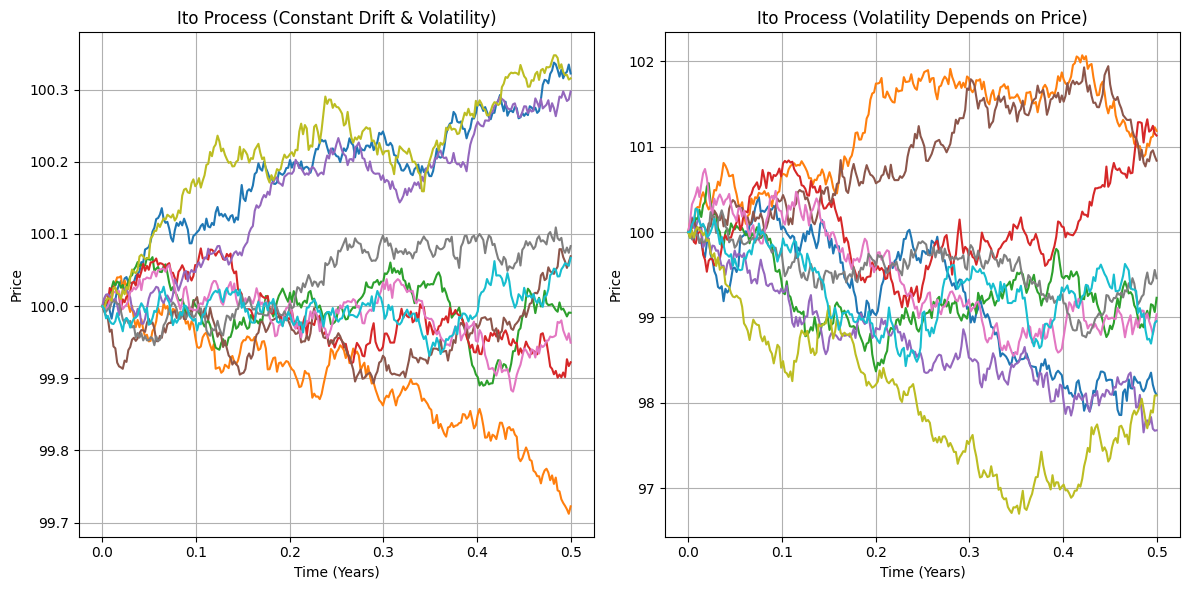

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def ito_process_simulation(S0, T, n_steps, n_sim, mu, sigma):
    """
    Simulates asset prices using a general Itô process.

    Args:
        S0 (float): Initial asset price.
        T (float): Time horizon.
        n_steps (int): Number of time steps.
        n_sim (int): Number of simulation paths.
        mu (function): Drift rate function; takes S (price) and t (time) as input.
        sigma (function): Volatility function; takes S and t as input.

    Returns:
        tuple: (time_points, S_paths) where:
            time_points: Array of time points.
            S_paths: 2D array (n_steps+1 x n_sim) of simulated asset price paths.
    """

    dt = T / n_steps
    time_points = np.linspace(0, T, n_steps + 1)
    S_paths = np.zeros((n_steps + 1, n_sim))
    S_paths[0, :] = S0

    dW = np.random.standard_normal(size=(n_steps, n_sim)) * np.sqrt(dt)

    for t in range(1, n_steps + 1):
        current_S = S_paths[t - 1, :]
        current_time = time_points[t - 1]

        drift = mu(current_S, current_time) * dt
        diffusion = sigma(current_S, current_time) * dW[t - 1, :]

        S_paths[t, :] = current_S + drift + diffusion

    return time_points, S_paths


if __name__ == '__main__':
    # --- Example Usage ---
    S0 = 100  # Initial price
    T = 0.5     # Time horizon (years)
    n_steps = 252  # Daily time steps
    n_sim = 10    # Number of paths

    # Example: Simple Itô process with constant drift and volatility
    mu_const = lambda S, t: 0.1  # Constant drift of 10% per year
    sigma_const = lambda S, t: 0.2  # Constant volatility of 20%

    time, S_paths_const = ito_process_simulation(S0, T, n_steps, n_sim, mu_const, sigma_const)

    # Example: Itô process with volatility that changes with price (CEV-like)
    mu_const_drift = lambda S, t: 0.1
    sigma_price_dep = lambda S, t: 0.2 * np.power(S, 0.5)  # Volatility decreases as price increases

    time, S_paths_price_dep = ito_process_simulation(S0, T, n_steps, n_sim, mu_const_drift, sigma_price_dep)

    # --- Plotting ---
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(time, S_paths_const)
    plt.title('Ito Process (Constant Drift & Volatility)')
    plt.xlabel('Time (Years)')
    plt.ylabel('Price')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(time, S_paths_price_dep)
    plt.title('Ito Process (Volatility Depends on Price)')
    plt.xlabel('Time (Years)')
    plt.ylabel('Price')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [136]:

def calculate_mu_sigma(file_path, price_column):
    """
    Reads an Excel file, calculates and returns the mu and sigma for the given price column.

    Args:
        file_path (str): The path to the Excel file.
        price_column (str, optional): The name of the column containing price data. 
                                     Defaults to 'SET50'.

    Returns:
        tuple: A tuple containing mu (drift) and sigma (volatility).
    """

    # Read the Excel file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Ensure the 'Date' column is in datetime format for proper sorting
    df['Date'] = pd.to_datetime(df['Date'])

    # Sort the DataFrame by the 'Date' column
    df.sort_values(by='Date', inplace=True)

    # Convert the price column to numeric and handle invalid data
    df[price_column] = pd.to_numeric(df[price_column], errors='coerce')
    df.dropna(subset=[price_column], inplace=True)
    
    # Calculate the logarithmic returns
    df['Returns'] = np.log(df[price_column] / df[price_column].shift(1))

    # Drop the first row (which will have NaN as return)
    df.dropna(inplace=True)
    df = df[-126:]

    # Estimate mu (drift) and sigma (volatility)
    mu = df['Returns'].mean() * 252  # Annualized (assuming 252 trading days)
    sigma = df['Returns'].std() * np.sqrt(252)

    return mu, sigma

if __name__ == '__main__':
    file_path = 'Recent_set.csv'
    price_col = 'Price' # Replace with the actual path to your file
    mu, sigma = calculate_mu_sigma(file_path, price_col)
    
    print("Calculated mu:", mu)
    print("Calculated sigma:", sigma)

Calculated mu: -0.3661995355775157
Calculated sigma: 0.20062379545015566


Option Probabilities:
ITM: 0.9460
ATM: 0.0002
OTM: 0.0540


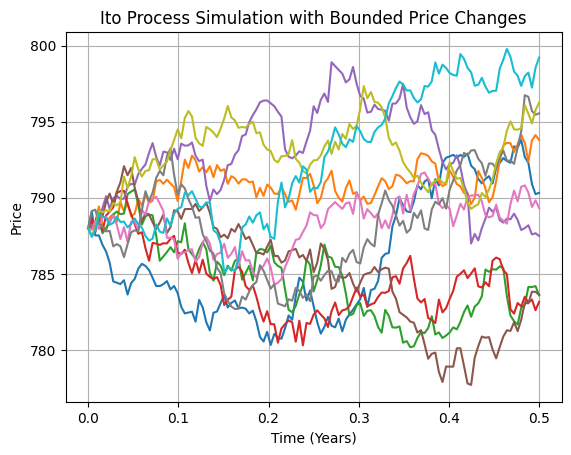

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def ito_process_bounded_simulation(S0, T, n_steps, n_sim, mu, sigma, max_change_pct, K):
    """
    Simulates asset prices using a general Itô process with bounded price changes.

    Args:
        S0 (float): Initial asset price.
        T (float): Time horizon.
        n_steps (int): Number of time steps.
        n_sim (int): Number of simulation paths.
        mu (function): Drift rate function.
        sigma (function): Volatility function.
        max_change_pct (float): Maximum percentage change from previous price.
        K (float): Strike price for option analysis.

    Returns:
        tuple: (time_points, S_paths) where:
            time_points: Array of time points.
            S_paths: 2D array of simulated asset price paths.
    """

    dt = T / n_steps
    time_points = np.linspace(0, T, n_steps + 1)
    S_paths = np.zeros((n_steps + 1, n_sim))
    S_paths[0, :] = S0

    dW = np.random.standard_normal(size=(n_steps, n_sim)) * np.sqrt(dt)

    for t in range(1, n_steps + 1):
        prev_S = S_paths[t - 1, :]
        current_time = time_points[t - 1]

        drift = mu(prev_S, current_time) * dt
        diffusion = sigma(prev_S, current_time) * dW[t - 1, :]
        
        # Limit the price change
        max_change = max_change_pct * prev_S
        dS = np.clip(drift + diffusion, -max_change, max_change)
        
        S_paths[t, :] = prev_S + dS

    return time_points, S_paths

def calculate_option_probabilities(S_paths, K):
    """
    Calculates the probability of option prices being ITM, ATM, and OTM.

    Args:
        S_paths (ndarray): Simulated asset price paths.
        K (float): Strike price.

    Returns:
        dict: Probabilities of ITM, ATM, and OTM.
    """

    final_prices = S_paths[-1, :]  # Prices at final time step
    itm_prob = np.mean(final_prices > K)
    atm_prob = np.mean(np.abs(final_prices - K) < 1e-2)  
    otm_prob = np.mean(final_prices < K)
    #final_prices comparisons are returned as boolean arrays, so we can use np.mean to get the probabilities

    return {"ITM": itm_prob, "ATM": atm_prob, "OTM": otm_prob}


if __name__ == '__main__':
    # --- Parameters ---
    S0 = 788# Initial price
    T = 1.0 / 2    # Time horizon (years)
    n_steps = int(252/2)  # Daily steps
    n_sim = 5000  # Number of simulation paths
    K = 775.0    # Strike price
    max_change_pct = 0.3  # Maximum 30% change

    mu_func = lambda S, t: mu # Example: Constant drift
    sigma_func = lambda S, t: sigma * np.power(S, 0.5) * 2 # *2 to scale the shock to be more significant

    # --- Simulation ---
    time, S_paths = ito_process_bounded_simulation(S0, T, n_steps, n_sim, mu_func, sigma_func, max_change_pct, K)

    # --- Option Probability Analysis ---
    probabilities = calculate_option_probabilities(S_paths, K)
    print("Option Probabilities:")
    print(f"ITM: {probabilities['ITM']:.4f}")
    print(f"ATM: {probabilities['ATM']:.4f}")
    print(f"OTM: {probabilities['OTM']:.4f}")

    # --- Plotting (Optional) ---
    plt.plot(time, S_paths[:, :10])  # Plot first 10 paths
    plt.title('Ito Process Simulation with Bounded Price Changes')
    plt.xlabel('Time (Years)')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()